In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Exploring the data

##### load data form ISLR website

In [2]:
college = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/College.csv', index_col=0)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


##### produce a numerical summary of the variables in the data set.

In [3]:
college.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000


##### produce a scatterplot matrix of the first five columns or variables of the data

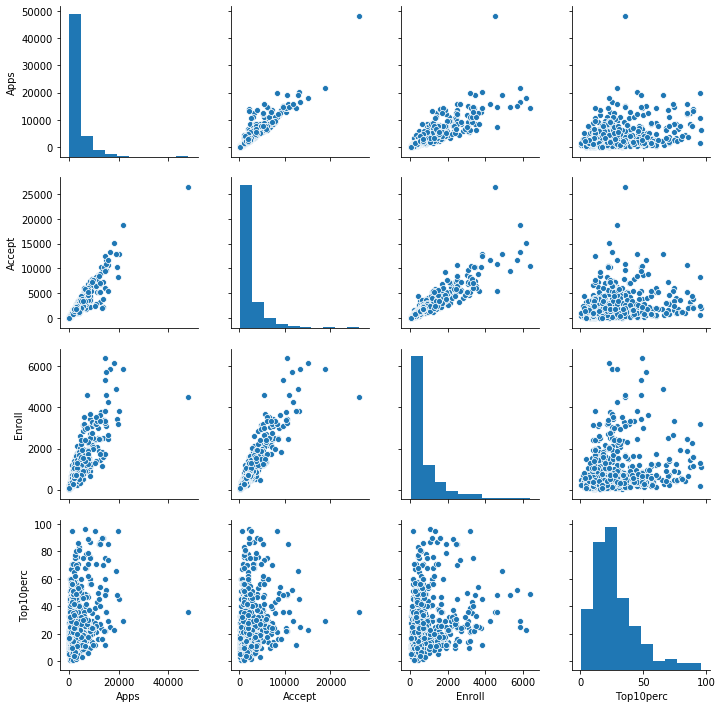

In [4]:
sns.pairplot(college.iloc[:, :5])

##### produce side-by-side boxplots of Outstate versus Private.

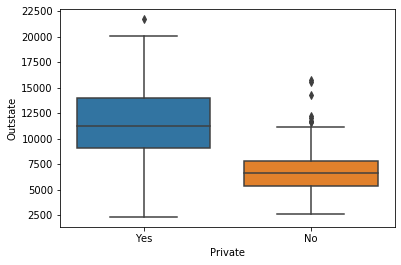

In [5]:
sns.boxplot(x=college['Private'], y=college['Outstate'])

##### Create a new qualitative variable, called Elite, by binning the Top10perc variable. 
We are going to divide universities into two groups based on whether or not the proportion of students coming from the top 10% of their high school classes exceeds 50 %.

In [0]:
college['Elite'] = college['Top10perc'] > 50

##### see how many elite universities there are.

In [7]:
college['Elite'].sum()

78

##### Now use the plot() function to produce side-by-side boxplots of Outstate versus Elite.

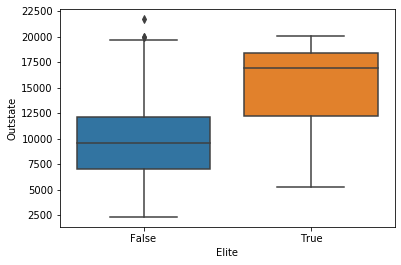

In [8]:

sns.boxplot(x=college['Elite'], y=college['Outstate'])

##### Use the hist() function to produce some histograms with differing numbers of bins for a few of the quantitative variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b5bb76be0>,
      dtype=object)

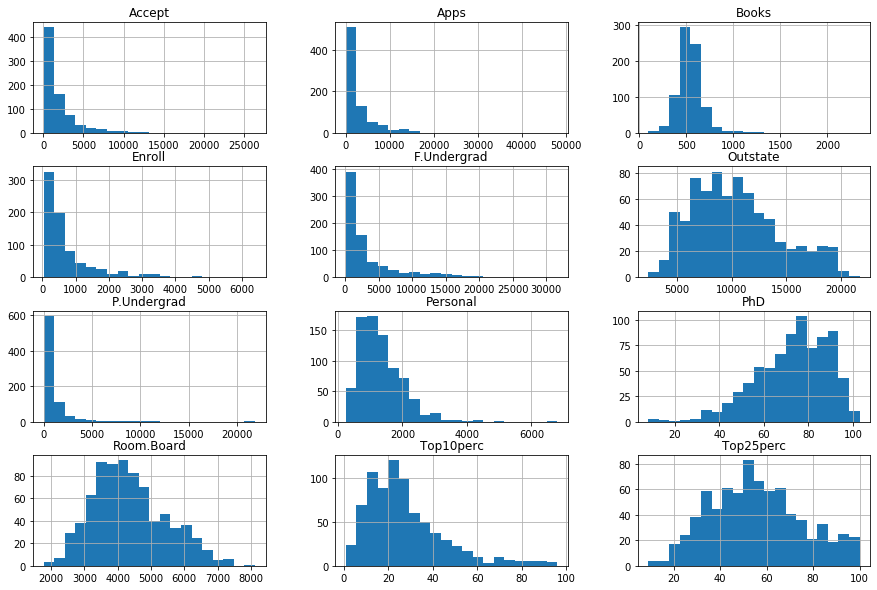

In [9]:
college.iloc[:,:13].hist(bins=20,figsize=(15,10))

##### A slightly prettier version using seaborn

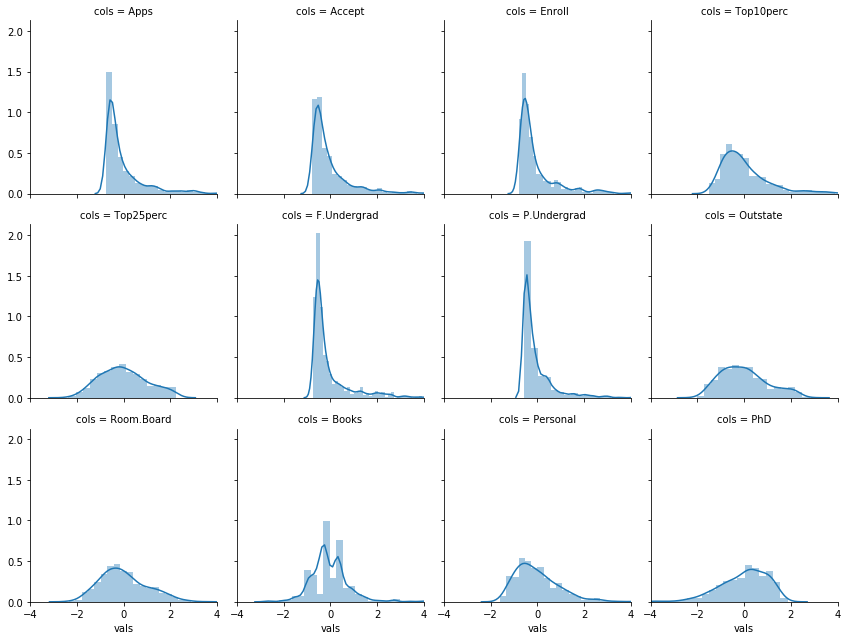

In [10]:
def scale(df, axis=0):
    return (df-df.mean(axis=axis))/(df.std(axis=axis))


feature_count = 12

# Remove units
df_norm = scale(college.iloc[:, 1:feature_count+1])
# Recast data into long format using melt
df_meltd = df_norm.melt(var_name='cols', value_name='vals')


# Plot grid of plots
g = sns.FacetGrid(df_meltd, col='cols', col_wrap=4)
g.map(sns.distplot, 'vals')
g.set(xlim=(-4, 4));

### Predicting the number of applications

In [11]:
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,False
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,False
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,False
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,True
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,False


##### Create dummies for text variables

In [12]:
college = pd.get_dummies(college, drop_first=True)
college.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Elite,Private_Yes
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,False,1
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,False,1
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,False,1
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,True,1
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,False,1


In [0]:
# Convert to floats
#college_df = college_df.astype(np.float64)

# Remove fullstops from col names
college = college.rename(index=str, columns={"F.Undergrad": "F_Undergrad", 
                                                   "P.Undergrad": "P_Undergrad",
                                                   "S.F.Ratio": "S_F_Ratio",
                                                   "perc.alumni": "perc_alumni",
                                                   "Grad.Rate": "Grad_Rate",
                                                   "Room.Board": "Room_Board"})

##### create X and y variables

In [0]:
response = 'Apps'
y = college[response]
X = college.drop(response, axis=1)

##### add polynomial features

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias=False) # exlude bias to avoid issues with subsequent scaling
X_poly = poly.fit_transform(X)
print('Converted {} base features into {} polynomial features.'.format(X.shape[1], X_poly.shape[1]))

Converted 18 base features into 189 polynomial features.


##### Split data into training and testing

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, X0_train, X0_test = train_test_split(X_poly, y, X, shuffle=True)

###### Standardize X variables

In [0]:
X_train = scale(X_train)
X_test = scale(X_test)
X0_train = scale(X0_train)
X0_test = scale(X0_test)


##### Model fit helper functions

In [0]:
def fit_model(modelCV, X_train=X_train, X_test=X_test, y_train=y_train):
  # fit a model
  modelCV.fit(X_train, y_train)

  # predict using a model
  y_pred_train = modelCV.predict(X_train)
  y_pred_test = modelCV.predict(X_test)

  # report prediction errors
  print('RMSE train: {:.5f}, RMSE test: {:.5f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))))

  return modelCV

def plot_mse(model, X_train=X_train, X_test=X_test, y_train=y_train, modtype='Ridge'):
  # fit a model
  model.fit(X_train, y_train)

  # compute MSE as a function of alpha 
  scores = []
  coefs = []
  for a in alphas:
      # set current alpha
      model.set_params(alpha=a)
      # save scores
      scores.append(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
      # save coefs
      coefs.append(model.coef_)

  # plot MSE in the test data
  ax = plt.gca()
  ax.plot(alphas, scores)
  ax.set_xscale('log')
  plt.axis('tight')
  plt.xlabel('alpha')
  plt.ylabel('MSE')
  plt.grid()
  plt.title(f'{modtype} coefficients as a function of the regularization')

##### Fit a linear model

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

ols = fit_model(LinearRegression(fit_intercept=True))

RMSE train: 492.74901, RMSE test: 1537.01579


##### Ridge regression

RMSE train: 608.69090, RMSE test: 955.74596
cv_alpha:  20.0923300256505


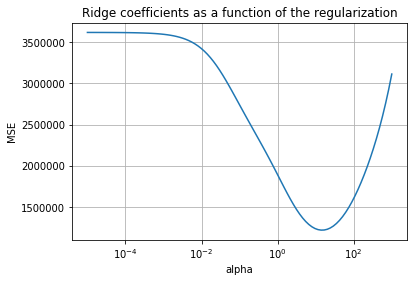

In [20]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

alphas = 10**np.linspace(-5,3,100)

ridgecv = RidgeCV(alphas=alphas,fit_intercept=True)
ridgecv = fit_model(ridgecv)
print('cv_alpha: ', ridgecv.alpha_)

plot_mse(Ridge(fit_intercept=True))

##### Lasso

RMSE train: 1054.96483, RMSE test: 1172.33379
cv_alpha:  29.15053062825182


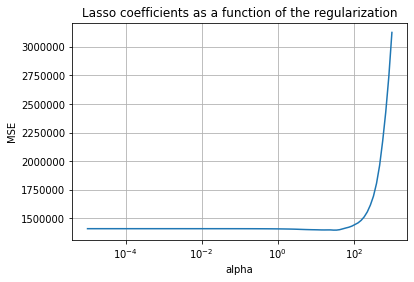

In [21]:
alphas = 10**np.linspace(-5,3,100)

lassocv = LassoCV(alphas=alphas,fit_intercept=True, cv=5, max_iter=1e6)
lassocv = fit_model(lassocv, X_train=X0_train, X_test=X0_test)
print('cv_alpha: ', lassocv.alpha_)

plot_mse(Lasso(fit_intercept=True, max_iter=1e6), X_train=X0_train, X_test=X0_test, modtype='Lasso')


Note that Lasso choses to impose zero penalty and keep all predictors.

##### Elastic net

In [22]:
alphas = 10**np.linspace(-5,3,100)

cv = ElasticNetCV(alphas=alphas, fit_intercept=True, max_iter=1e5, cv=5, l1_ratio=np.linspace(.05, 1.0, 20))
fit_model(cv, X_train=X0_train, X_test=X0_test) 
print('cv_alpha: ', cv.alpha_)
print('l1_ratio: ', cv.l1_ratio_)

#plot_mse(ElasticNet(fit_intercept=True, max_iter=1e5))


RMSE train: 1054.96483, RMSE test: 1172.33379
cv_alpha:  29.15053062825182
l1_ratio:  1.0


ElasticNet simply runs lasso with zero regularization in this case. The error is larger, however, than Ridge on the data expanded with polynomials.

##### Random forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
cv = RandomForestRegressor(random_state=0, n_estimators=1000, bootstrap=True, n_jobs=10)
rf = fit_model(cv, X_train=X0_train, X_test=X0_test) # use the original set of characteristics (not expanded)



RMSE train: 558.23631, RMSE test: 1126.06225


RandomForest work the best in the training data, but is dominated by Ridge (with polynomials) in the test data. It is still better than Lasso, Ridge, and ElasticNet using original data with no polynomials though.